# 2. Prepare Data

From https://machinelearningmastery.com/process-for-working-through-machine-learning-problems/

I preface data preparation with a data analysis phase that involves summarizing the attributes and visualizing them using scatter plots and histograms. I also like to describe in detail each attribute and relationships between attributes. This grunt work forces me to think about the data in the context of the problem before it is lost to the algorithms

The actual data preparation process is three step as follows:

* Step 1: Data Selection: Consider what data is available, what data is missing and what data can be removed.
* Step 2: Data Preprocessing: Organize your selected data by formatting, cleaning and sampling from it.
* Step 3: Data Transformation: Transform preprocessed data ready for machine learning by engineering features using scaling, attribute decomposition and attribute aggregation.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression

## Retrieve resources
The data directory will be ignored by git and you will need to retrieve manually the resources:

extract the contents of this zip file into the **data** subdirectory: 
https://s3.amazonaws.com/drivendata/data/1/public/cd238763-ed29-4a46-8584-f9334d57ec94.zip
you should have "data/TrainingSet.csv" and "data/SubmissionRows.csv"


you will need as well to put this file in the **data/** folder: 
https://gist.githubusercontent.com/pamelafox/986163/raw/f5f9db4f1b287804fd07ffb3296ed0036292bc7a/countryinfo.py

In [3]:
df = pd.read_csv("data/TrainingSet.csv")

In [4]:
# Looks at the first few lines to get an idea what the actual data looks like
df.head(3)

,Unnamed: 0,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...


In [5]:
# Last few lines
df.tail(3)

,Unnamed: 0,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
195399,286115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,30.2,NaN,Zimbabwe,SG.VAW.NEGL.ZS,Women who believe a husband is justified in be...
195400,286116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,24.3,NaN,Zimbabwe,SG.VAW.REFU.ZS,Women who believe a husband is justified in be...
195401,286117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.0,57.2,57.5,57.7,57.9,58.1,58.3,Zimbabwe,SH.DYN.AIDS.FE.ZS,Women's share of population ages 15+ living wi...


The first column looks like a row ID, let's double check that it's the case

In [6]:
df.iloc[:,0].nunique() == df.shape[0]

True

There are as many rows in the dataframe as identifiers in the first column, let's reload the data using the first column as the index

In [7]:
df = pd.read_csv('data/TrainingSet.csv', index_col=0)

In [8]:
df.head(3)

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...


In [9]:
# What column names do we have
df.columns

Index(['1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
       '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
       '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
       '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
       '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
       '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
       '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
       'Country Name', 'Series Code', 'Series Name'],
      dtype='object')

Let's rename the columns to remove gaps and unnecessary info and to ease further coding when selecting sets of columns

In [10]:
df.columns.values[-3:]

array(['Country Name', 'Series Code', 'Series Name'], dtype=object)

In [11]:
df.columns = [year[:4] for year in df.columns][:-3] + [col.replace(' ', '_') for col in df.columns.values[-3:]]

In [12]:
# Get some basic stats about the training data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
1972,64945.0,1.630638e+11,4.261616e+12,-1.047939e+14,3.176702,63.940000,5.007000e+06,2.681335e+14
1973,64443.0,1.839488e+11,4.749746e+12,-1.128889e+14,3.550009,66.317365,7.131000e+06,2.943467e+14
1974,64966.0,2.089534e+11,5.378336e+12,-7.134161e+13,4.000000,70.485627,9.250000e+06,3.186506e+14
1975,66973.0,2.148826e+11,5.647070e+12,-8.269588e+13,3.671917,71.886131,1.108200e+07,3.383541e+14
1976,67717.0,2.321517e+11,6.120314e+12,-9.735652e+13,4.595300,74.563536,1.290000e+07,3.586152e+14
1977,69735.0,2.413682e+11,6.398377e+12,-9.433422e+13,5.000000,78.944621,1.540950e+07,3.895869e+14
1978,69763.0,2.540583e+11,6.710724e+12,-9.495898e+13,4.901495,78.638080,1.922850e+07,4.254506e+14
1979,69906.0,2.742810e+11,7.213662e+12,-5.362479e+13,5.000000,81.408655,2.409375e+07,4.556262e+14
1980,75250.0,2.674858e+11,7.381164e+12,-5.649790e+13,5.682373,81.829695,2.419225e+07,5.039050e+14
1981,78034.0,2.774415e+11,7.942777e+12,-5.437839e+13,5.000000,78.137173,2.317875e+07,5.815794e+14


In [13]:
# Find unique countries
df.Country_Name.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Ethiopia', 'Faeroe Islands', 'Fiji', 'Finland',
       'France', 

In [14]:
print ("Number of distinct countries {}".format(df.Country_Name.nunique()))

Number of distinct countries 214


In [15]:
# Pandas can also tell us how many unique values are in each column
df.nunique()

1972             47534
1973             47677
1974             48521
1975             50269
1976             51279
1977             53185
1978             53578
1979             53882
1980             58032
1981             59693
1982             60516
1983             60615
1984             61088
1985             62170
1986             62726
1987             63482
1988             63814
1989             65248
1990             78732
1991             77506
1992             80642
1993             81969
1994             83600
1995             88951
1996             89206
1997             90177
1998             90256
1999             94957
2000             99186
2001             99397
2002            102167
2003            101224
2004            102863
2005            111682
2006            112989
2007            115182
Country_Name       214
Series_Code       1305
Series_Name       1305
dtype: int64

In [16]:
# Or the percentage of non-nul data in each column
(df.count() / df.shape[0] * 100)

1972             33.236610
1973             32.979703
1974             33.247357
1975             34.274470
1976             34.655224
1977             35.687966
1978             35.702296
1979             35.775478
1980             38.510353
1981             39.935108
1982             40.437662
1983             40.420262
1984             40.701733
1985             41.461705
1986             41.685858
1987             42.349618
1988             42.600383
1989             44.181226
1990             54.735878
1991             54.754301
1992             57.442094
1993             58.624272
1994             59.785980
1995             63.698427
1996             63.650321
1997             64.321757
1998             64.453793
1999             66.979867
2000             71.927104
2001             70.000819
2002             71.808375
2003             71.216774
2004             72.864658
2005             82.672644
2006             81.313395
2007             82.699256
Country_Name    100.000000
S

## Submission data

In [17]:
# read the data containing the rows we need to predict
df_submission = pd.read_csv('data/SubmissionRows.csv', index_col=0)

In [18]:
df_submission.head(10)

,2008 [YR2008],2012 [YR2012]
559,NaN,NaN
618,NaN,NaN
753,NaN,NaN
1030,NaN,NaN
1896,NaN,NaN
1955,NaN,NaN
2090,NaN,NaN
2690,NaN,NaN
3233,NaN,NaN
3292,NaN,NaN


In [19]:
df_submission.shape

(737, 2)

As we have the row ID as an index for both the training data (df) and the submission we can directly extract the data related to the submission index

In [20]:
df_submission_in_data = df.loc[df_submission.index]

In [21]:
df_submission_in_data.Country_Name.nunique()

206

Let's have a look at the Series Code in the sudmission data

In [22]:
submission_codes = df_submission_in_data.Series_Code.unique()
len(submission_codes)

7

In [23]:
submission_codes

array(['7.8', '8.16', '4.1', '6.1', '2.1', '5.1', '6.7'], dtype=object)

In [24]:
df.Series_Code.isin(submission_codes).sum()

1118

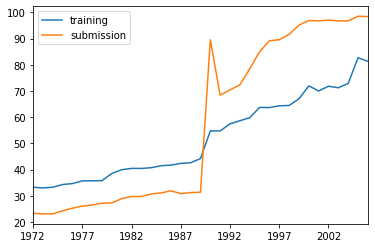

In [25]:
# Or the percentage of non-nul data in each column
(df.count() / df.shape[0] * 100).iloc[:-4].plot(label='training')
(df_submission_in_data.count() / df_submission_in_data.shape[0] * 100).iloc[:-4].plot(label='submission')
plt.legend();

We have learned from the analysis of the submission data that:
1. Most countries are represented in the submission data, 206 out of 214
2. Only 7 codes are used and we have 1118 data points in the training data with these codes
3. The amount of missing data is fairly similar between the training and submission data

# What are we trying to achieve?

We have 737 indicators from 206 countries with data from 1972 to 2007.  
We would like to predict what these indicators will be in 2008 and 2012.  

A very simplistic way of predicting the future values of these indicators would be to do a simple linear regression for indicators with more than 1 data point in the last 35 years or use the only data point we have for indicators with a single value.

**Let's try to code this simplistic version**

In [26]:
def make_prediction(row):
    data = row.loc['1972':'2007']
    nbr_data_points = data.count()
    if nbr_data_points < 2:
        pred_2008 = data.dropna().values
        pred_2012 = pred_2008
    
    else:
        years = data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = data.dropna().values
        
        #linear regression
        regr = LinearRegression()
        regr.fit(years, values)
        
        #predictions
        pred_2008 = regr.predict(np.array([2008]).reshape(-1, 1))
        pred_2012 = regr.predict(np.array([2012]).reshape(-1, 1))
        
    return pred_2008[0], pred_2012[0]

In [27]:
df_simple_preds = pd.DataFrame(df_submission_in_data.apply(make_prediction, axis=1).tolist(),\
                               index=df_submission_in_data.index, columns=['2008','2012'])

In [28]:
df_simple_preds.head()

,2008,2012
559,0.465706,0.580451
618,0.012712,0.016830
753,0.087664,0.065155
1030,0.001000,0.001000
1896,0.961802,0.960782


Let's visualise the results

In [262]:
def plot_predictions(df_train, df_pred, nbr_rows):
    np.random.seed(3)
    rows_to_plot = np.random.choice(df_train.index.values, nbr_rows, replace=False)
    
    cmap = get_cmap('Set1')
    colors = cmap.colors
        
    fig, ax = plt.subplots(figsize=(16,10))
    for i,j in zip(rows_to_plot, range(nbr_rows)):
        if j >= len(colors): j -= len(colors)
        ax.plot(df_train.loc[i, '1972':'2007'].dropna().index.astype(int), 
                df_train.loc[i, '1972':'2007'].dropna().values, 
                label=df_train.loc[i, 'Country_Name']+ '/' + df_train.loc[i, 'Series_Name'],
                marker='o',
                linewidth=4,
                alpha=0.5,
                color=colors[j])
                
        ax.plot(df_pred.loc[i].index.astype(int), 
                df_pred.loc[i].values,
                marker='s',
                linewidth=4,
                markersize=10,
                color=colors[j])

    plt.legend(loc=2)

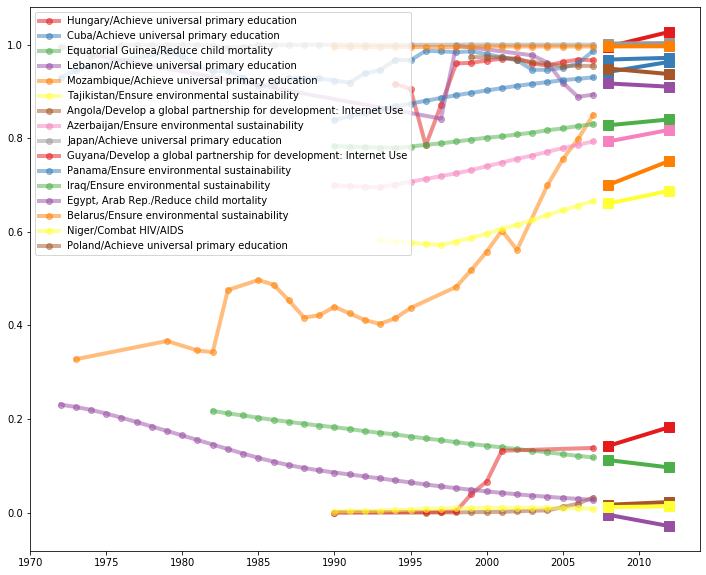

In [30]:
plot_predictions(df_submission_in_data, df_simple_preds, 16)

These results are simplistic but not too bad for most indicators.  
We could improve easily the results by doing a polynomial regression or another type of more sophisticated regression.  

But what we are trying to achieve is find correlation between these indicators and all the other indicators present in the dataset to improve our predictions as we have a lot of missing data.  
And these predictions using correlations are where the difficulty of this exercise lies.

## Separating sub codes from the main code values

Let's first make all values upper case to make sure we compare correctly the codes

In [31]:
df.Series_Code

0               allsi.bi_q1
1               allsp.bi_q1
2               allsa.bi_q1
4             allsi.gen_pop
5             allsp.gen_pop
6             allsa.gen_pop
8             allsi.cov_pop
9             allsp.cov_pop
10            allsa.cov_pop
11            lm_ub.cov_pop
12            PA.NUS.PPP.05
13        PA.NUS.PRVT.PP.05
16                      2.1
17           SE.PRM.TENR.FE
18           SE.PRM.TENR.MA
20           NY.ADJ.NNTY.KD
21           NY.ADJ.NNTY.CD
23        NY.ADJ.NNTY.PC.KD
24        NY.ADJ.NNTY.PC.CD
29        NY.ADJ.DCO2.GN.ZS
30           NY.ADJ.DCO2.CD
31        NY.ADJ.DKAP.GN.ZS
32           NY.ADJ.DKAP.CD
33        NY.ADJ.AEDU.GN.ZS
34           NY.ADJ.AEDU.CD
35        NY.ADJ.DNGY.GN.ZS
36           NY.ADJ.DNGY.CD
38        NY.ADJ.DMIN.GN.ZS
39           NY.ADJ.DMIN.CD
40        NY.ADJ.DRES.GN.ZS
                ...        
286085          SP.UWT.TFRT
286086          SP.URB.TOTL
286087    SP.URB.TOTL.IN.ZS
286088          SP.URB.GROW
286089       DT.DOD.

In [32]:
df.Series_Code = df.Series_Code.str.upper()

In [33]:
df.Series_Code.nunique()

1305

We have 1305 different code names but most of them include similar codes which might be helpful when trying to find similarity within the data to help with our predictions.  
We will create a function that extract each of the subcodes and save them in separate column in function of their order in the code serie.

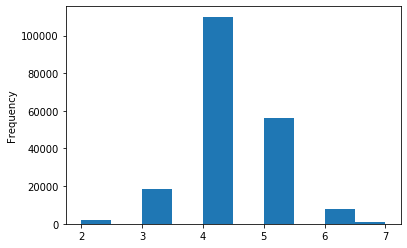

In [34]:
# Exploring the code structure
df.Series_Code.apply(lambda x: len(x.split('.'))).plot(kind='hist');

In [35]:
row_longest_code_serie = df.Series_Code.apply(lambda x: len(x.split('.'))).idxmax()
df.loc[row_longest_code_serie, 'Series_Code']

'SL.EMP.TOTL.SP.FE.NE.ZS'

In [36]:
len(df.loc[row_longest_code_serie, 'Series_Code'].split('.'))

7

We have a maximum of 7 separate elements in the code structure

In [37]:
def explode_code(s):
    # split the code name using the '.'
    s_split = s.split('.')
    
    # save the first and last value of the serie
    last = s_split[-1]
    first = s_split[0]
    
    # reverse the order of the code series to keep the last code as first and first as last
    #s_split = s_split[::-1]
    
    # add NaN values until the list has 7 items in it
    s_split += [np.NaN] * (7 - len(s_split))
    
    # add the first and last value to the list
    s_split += [first, last]
    
    return s_split

In [38]:
# We first create 9 new columns for each of the output of the function explode_code
# fill these columns with the ouput of the explode_code function by converting its ouput to a list and then to a dataframe using the orginal index of the dataframe

df[['Series_Code_'+ str(i) for i in range(7)] + ['Series_Code_First', 'Series_Code_Last']] =\
    pd.DataFrame(df.Series_Code.apply(explode_code).tolist(), index=df.index)

In [39]:
df.iloc[:5,-11:]

,Series_Code,Series_Name,Series_Code_0,Series_Code_1,Series_Code_2,Series_Code_3,Series_Code_4,Series_Code_5,Series_Code_6,Series_Code_First,Series_Code_Last
0,ALLSI.BI_Q1,(%) Benefits held by 1st 20% population - All ...,ALLSI,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSI,BI_Q1
1,ALLSP.BI_Q1,(%) Benefits held by 1st 20% population - All ...,ALLSP,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSP,BI_Q1
2,ALLSA.BI_Q1,(%) Benefits held by 1st 20% population - All ...,ALLSA,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSA,BI_Q1
4,ALLSI.GEN_POP,(%) Generosity of All Social Insurance,ALLSI,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSI,GEN_POP
5,ALLSP.GEN_POP,(%) Generosity of All Social Protection,ALLSP,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSP,GEN_POP


In [40]:
df.iloc[-5:,-11:]

,Series_Code,Series_Name,Series_Code_0,Series_Code_1,Series_Code_2,Series_Code_3,Series_Code_4,Series_Code_5,Series_Code_6,Series_Code_First,Series_Code_Last
286113,SG.VAW.BURN.ZS,Women who believe a husband is justified in be...,SG,VAW,BURN,ZS,NaN,NaN,NaN,SG,ZS
286114,SG.VAW.GOES.ZS,Women who believe a husband is justified in be...,SG,VAW,GOES,ZS,NaN,NaN,NaN,SG,ZS
286115,SG.VAW.NEGL.ZS,Women who believe a husband is justified in be...,SG,VAW,NEGL,ZS,NaN,NaN,NaN,SG,ZS
286116,SG.VAW.REFU.ZS,Women who believe a husband is justified in be...,SG,VAW,REFU,ZS,NaN,NaN,NaN,SG,ZS
286117,SH.DYN.AIDS.FE.ZS,Women's share of population ages 15+ living wi...,SH,DYN,AIDS,FE,ZS,NaN,NaN,SH,ZS


## Adding the continent related to each country

In [41]:
from data import countryinfo

In [42]:
df_continent = pd.DataFrame(countryinfo.countries)

In [43]:
df_continent.columns

Index(['capital', 'code', 'continent', 'name', 'timezones'], dtype='object')

We copy the continent information from the dataframe using the country names as index

In [44]:
# we use the map function of pandas for looking the the country name in the index of the second df and outputing the continent information
df['Continent'] = df.Country_Name.map(df_continent.set_index('name').continent)

In [45]:
df[['Continent','Country_Name']].iloc[::15000]

,Continent,Country_Name
0,Asia,Afghanistan
22951,Europe,Belarus
42230,NaN,Cabo Verde
63269,Europe,Croatia
85989,Oceania,Fiji
108623,North America,Haiti
129577,Asia,Jordan
153088,NaN,"Macao SAR, China"
174444,Europe,Montenegro
196608,North America,Panama


We have some countries with names that are different from our list of country/continent

In [46]:
df[df.Continent.isna()].Country_Name.unique()

array(['American Samoa', 'Aruba', 'Bahamas, The', 'Bermuda', 'Cabo Verde',
       'Cayman Islands', 'Channel Islands', 'China', 'Congo, Dem. Rep.',
       'Congo, Rep.', "Cote d'Ivoire", 'Curacao', 'Egypt, Arab Rep.',
       'Faeroe Islands', 'French Polynesia', 'Gambia, The', 'Greenland',
       'Guam', 'Hong Kong SAR, China', 'Iran, Islamic Rep.', 'Ireland',
       'Isle of Man', 'Korea, Dem. Rep.', 'Korea, Rep.', 'Kosovo',
       'Kyrgyz Republic', 'Lao PDR', 'Macao SAR, China', 'Macedonia, FYR',
       'Micronesia, Fed. Sts.', 'Netherlands', 'New Caledonia',
       'Northern Mariana Islands', 'Puerto Rico', 'Russian Federation',
       'Sao Tome and Principe', 'Sint Maarten (Dutch part)',
       'Slovak Republic', 'South Sudan', 'St. Kitts and Nevis',
       'St. Lucia', 'St. Martin (French part)',
       'St. Vincent and the Grenadines', 'Syrian Arab Republic',
       'Timor-Leste', 'Turks and Caicos Islands', 'Venezuela, RB',
       'Virgin Islands (U.S.)', 'West Bank and Gaza', 

In [47]:
df[df.Country_Name.str.contains('Bahamas', case=False)].Country_Name.unique()

array(['Bahamas, The'], dtype=object)

In [48]:
df_continent[df_continent.name.str.contains('Bahamas', case=False)]

,capital,code,continent,name,timezones
21,Nassau,BS,North America,Bahamas,[America/Nassau]


### Continent missing values

Let's do some fuzzy matching to find the most likely candidate for the country listed in our database

In [49]:
!pip3 install fuzzywuzzy

  Using cached https://files.pythonhosted.org/packages/d8/f1/5a267addb30ab7eaa1beab2b9323073815da4551076554ecc890a3595ec9/fuzzywuzzy-0.17.0-py2.py3-none-any.whl


In [50]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/home/jeremie/.local/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [51]:
country_bad_name = df[df.Continent.isna()].Country_Name.unique()
countries = df_continent.name.values

In [52]:
country = country_bad_name[0]
print(country)
process.extractOne(country, countries)

American Samoa


('Samoa', 90)

In [53]:
df_fuzzy = pd.DataFrame([[country]+list(process.extractOne(country, countries)) for country in country_bad_name], 
                        columns=['training_name', 'replacement_name', 'score'])

In [54]:
df_fuzzy.head()

,training_name,replacement_name,score
0,American Samoa,Samoa,90
1,Aruba,Barbados,72
2,"Bahamas, The",Bahamas,90
3,Bermuda,Peru,68
4,Cabo Verde,Cape Verde,80


In [55]:
# Let's add the continent to this dataframe
df_fuzzy['Continent'] = df_fuzzy.replacement_name.map(df_continent.set_index('name').continent)

In [56]:
df_fuzzy.head()

,training_name,replacement_name,score,Continent
0,American Samoa,Samoa,90,Oceania
1,Aruba,Barbados,72,North America
2,"Bahamas, The",Bahamas,90,North America
3,Bermuda,Peru,68,South America
4,Cabo Verde,Cape Verde,80,Africa


In [57]:
# Replacement_name that we are most sure about
df_fuzzy[df_fuzzy.score > 86]

,training_name,replacement_name,score,Continent
0,American Samoa,Samoa,90,Oceania
2,"Bahamas, The",Bahamas,90,North America
7,China,People's Republic of China,90,Asia
10,Cote d'Ivoire,CÃ´te d'Ivoire,96,Africa
12,"Egypt, Arab Rep.",Egypt,90,Africa
15,"Gambia, The",The Gambia,95,Africa
19,"Iran, Islamic Rep.",Iran,90,Asia
20,Ireland,Republic of Ireland,90,Europe
28,"Macedonia, FYR",Macedonia,90,Europe
30,Netherlands,Kingdom of the Netherlands,90,Europe


In [58]:
# Replacement_name that we are most sure about
df_fuzzy[df_fuzzy.score < 86]

,training_name,replacement_name,score,Continent
1,Aruba,Barbados,72,North America
3,Bermuda,Peru,68,South America
4,Cabo Verde,Cape Verde,80,Africa
5,Cayman Islands,Solomon Islands,69,Oceania
6,Channel Islands,Marshall Islands,71,Oceania
11,Curacao,Cuba,68,North America
13,Faeroe Islands,Marshall Islands,67,Oceania
14,French Polynesia,Syria,68,Asia
16,Greenland,Grenada,75,North America
17,Guam,Nicaragua,77,North America


We are missing a few easy fix like Congo and Korea

Let's fill the missing continents using the above rule

In [59]:
countries_to_correct = df.Country_Name.isin(df_fuzzy[df_fuzzy.score > 86].training_name)

df.loc[countries_to_correct, 'Continent'] =\
    df.loc[countries_to_correct, 'Country_Name'].map(
        df_fuzzy[df_fuzzy.score > 86].set_index('training_name').Continent)

#### Let's redo the above fuzzy matching but trying a different metric to catch more missing values

In [60]:
country_bad_name = df[df.Continent.isna()].Country_Name.unique()
countries = df_continent.name.values

In [61]:
country = country_bad_name[5]
print(country)
print(process.extractOne(country, countries))
print(process.extractOne(country, countries, scorer=fuzz.ratio))
print(process.extractOne(country, countries, scorer=fuzz.partial_ratio))
print(process.extractOne(country, countries, scorer=fuzz.token_sort_ratio))
print(process.extractOne(country, countries, scorer=fuzz.token_set_ratio))
print(process.extractOne(country, countries, scorer=fuzz.partial_token_set_ratio))

Congo, Dem. Rep.
('Democratic Republic of the Congo', 86)
("CÃ´te d'Ivoire", 48)
('Togo', 75)
('Republic of the Congo', 59)
('Republic of the Congo', 59)
('Democratic Republic of the Congo', 100)


In [62]:
df_fuzzy = pd.DataFrame([[country]+list(process.extractOne(country, 
                                                           countries, 
                                                           scorer=fuzz.ratio
                                                          )) for country in country_bad_name], 
                        columns=['training_name', 'replacement_name', 'score'])

In [63]:
# Let's add the continent to this dataframe
df_fuzzy['Continent'] = df_fuzzy.replacement_name.map(df_continent.set_index('name').continent)

In [64]:
# Replacement_name that we are most sure about
df_fuzzy[df_fuzzy.score > 79]

,training_name,replacement_name,score,Continent
2,Cabo Verde,Cape Verde,80,Africa
26,St. Lucia,Saint Lucia,80,North America


Let's fill the missing continents using the above rule

In [65]:
countries_to_correct = df.Country_Name.isin(df_fuzzy[df_fuzzy.score > 79].training_name)

df.loc[countries_to_correct, 'Continent'] =\
    df.loc[countries_to_correct, 'Country_Name'].map(
        df_fuzzy[df_fuzzy.score > 79].set_index('training_name').Continent)

In [66]:
len(countries_to_correct[countries_to_correct==True])

1978

#### Manual corrections for Korea, Congo and China

In [67]:
df_continent[df_continent.name.str.contains('congo', case=False)]

,capital,code,continent,name,timezones
27,Kinshasa,CD,Africa,Democratic Republic of the Congo,"[Africa/Kinshasa, Africa/Lubumbashi]"
28,Brazzaville,CG,Africa,Republic of the Congo,[Africa/Brazzaville]


In [68]:
df_continent[df_continent.name.str.contains('korea', case=False)]

,capital,code,continent,name,timezones
78,Pyongyang,KP,Asia,North Korea,[Asia/Pyongyang]
79,Seoul,KR,Asia,South Korea,[Asia/Seoul]


In [69]:
df.loc[df.Country_Name.str.contains('congo', case=False), 'Continent'] = 'Africa'
df.loc[df.Country_Name.str.contains('korea', case=False), 'Continent'] = 'Asia'
df.loc[df.Country_Name.str.contains('china', case=False), 'Continent'] = 'Asia'

What is left in our missing continent?

In [70]:
country_bad_name = df[df.Continent.isna()].Country_Name.unique()
country_bad_name

array(['Aruba', 'Bermuda', 'Cayman Islands', 'Channel Islands', 'Curacao',
       'Faeroe Islands', 'French Polynesia', 'Greenland', 'Guam',
       'Isle of Man', 'Kosovo', 'Kyrgyz Republic', 'Lao PDR',
       'Micronesia, Fed. Sts.', 'New Caledonia',
       'Northern Mariana Islands', 'Puerto Rico',
       'Sint Maarten (Dutch part)', 'Slovak Republic',
       'St. Martin (French part)', 'Timor-Leste',
       'Turks and Caicos Islands', 'Virgin Islands (U.S.)',
       'West Bank and Gaza'], dtype=object)

In [71]:
len(country_bad_name)

24

In [72]:
df.Country_Name.isin(country_bad_name).sum() / df.shape[0] * 100

4.554712848384356

In [73]:
df_submission_in_data.Country_Name.isin(country_bad_name).sum() / df_submission_in_data.shape[0] * 100

5.020352781546811

We have less than 5% of the data with a missing continent in the training and submission data so we can probably leave it as it is and just replace it with Missing

In [74]:
df.loc[df.Country_Name.isin(country_bad_name), 'Continent'] = 'Missing'

In [75]:
df.head()

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,Series_Code_0,Series_Code_1,Series_Code_2,Series_Code_3,Series_Code_4,Series_Code_5,Series_Code_6,Series_Code_First,Series_Code_Last,Continent
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSI,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSI,BI_Q1,Asia
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSP,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSP,BI_Q1,Asia
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSA,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSA,BI_Q1,Asia
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSI,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSI,GEN_POP,Asia
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSP,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSP,GEN_POP,Asia


## Exploring the subcodes

In [76]:
from collections import Counter

10 most common subcodes

In [77]:
Counter(df.loc[:, 'Series_Code_0':'Series_Code_Last'].values.flat).most_common(10)

[(nan, 533716),
 ('ZS', 149410),
 ('CD', 87836),
 ('DT', 58457),
 ('NY', 33124),
 ('SE', 32098),
 ('SL', 30580),
 ('NE', 27561),
 ('SH', 21568),
 ('CN', 18366)]

Most common codes for each subcode column ignoring the nan values

In [78]:
def most_common_code(array, codes):
    array_notna = array[~pd.isna(array)]
    common_code = np.array(Counter(array_notna).most_common(codes))[:,0]
    common_code = np.append(common_code, [np.nan]*(codes-len(common_code)))
    return common_code

In [79]:
pd.DataFrame(data= np.apply_along_axis(func1d=most_common_code, 
                                       arr=df.loc[:, 'Series_Code_0':'Series_Code_Last'].values,
                                       axis=0,
                                      codes=15), 
             columns=df.loc[:, 'Series_Code_0':'Series_Code_Last'].columns)

,Series_Code_0,Series_Code_1,Series_Code_2,Series_Code_3,Series_Code_4,Series_Code_5,Series_Code_6,Series_Code_First,Series_Code_Last
0,DT,VAL,TOTL,CD,ZS,ZS,ZS,DT,ZS
1,NY,TAX,MRCH,ZS,ZG,NE,nan,NY,CD
2,SE,PRM,PRVT,FE,UN,CE,nan,SE,CN
3,SL,GDP,GNFS,CN,WT,KD,nan,SL,KD
4,NE,TLF,DPPG,MA,KD,ZG,nan,NE,KN
5,SH,CON,PCAP,KD,FE,nan,nan,SH,ZG
6,TM,SEC,MANF,KN,WD,nan,nan,TM,XQ
7,EN,ADJ,MKTP,GD,NE,nan,nan,EN,UN
8,SP,GSR,DURS,XQ,CD,nan,nan,SP,WT
9,IC,ATM,1524,GN,MA,nan,nan,IC,FE


In [80]:
df.head()

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,Series_Code_0,Series_Code_1,Series_Code_2,Series_Code_3,Series_Code_4,Series_Code_5,Series_Code_6,Series_Code_First,Series_Code_Last,Continent
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSI,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSI,BI_Q1,Asia
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSP,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSP,BI_Q1,Asia
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSA,BI_Q1,NaN,NaN,NaN,NaN,NaN,ALLSA,BI_Q1,Asia
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSI,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSI,GEN_POP,Asia
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ALLSP,GEN_POP,NaN,NaN,NaN,NaN,NaN,ALLSP,GEN_POP,Asia


explore

- correlation on 1 indicator between multiple countries of a continent
- a bundle of indicators on the same country

for each country, what indicators are most correlated to our 7 target indicators

In [81]:
submission_codes

array(['7.8', '8.16', '4.1', '6.1', '2.1', '5.1', '6.7'], dtype=object)

#### What is a correlation matrix?
https://en.wikipedia.org/wiki/Covariance_matrix

#### Visual example of a correlation matrix
![](https://www.displayr.com/wp-content/uploads/2018/07/correlation-matrix-3-768x601.png)

In [82]:
def top_corr(df, country, ind):
    df_country = df[df['Country_Name'] == country]
    
    data = df_country.set_index('Series_Code').loc[:,'1972':'2007'].T
    coeff = data.corr().loc[ind].abs()
    coeff.sort_values(inplace=True, ascending=False)
    
    return coeff.iloc[40:50]
top_corr(df,"Afghanistan","7.8")

Series_Code
DT.AXA.OFFT.CD       1.0
SH.STA.OWGH.ZS       1.0
DT.IXA.DPPG.CD.CG    1.0
GC.REV.XGRT.GD.ZS    1.0
FD.AST.PRVT.GD.ZS    1.0
GC.XPN.TOTL.GD.ZS    1.0
DT.NFL.MLAT.CD       1.0
DT.DOD.DECT.GN.ZS    1.0
DT.DOD.DLXF.CD       1.0
DT.DOD.PUBS.CD       1.0
Name: 7.8, dtype: float64

### Plotting one target indicator [Environmental Sustainability (7.8)] for Afghanistan

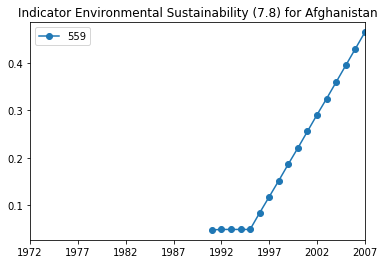

In [83]:
df_afghanistan_7_8 = df[ (df["Country_Name"] == "Afghanistan") & (df["Series_Code"] == "7.8")]
df_afghanistan_7_8_1972_to_2007 = df_afghanistan_7_8.loc[:, "1972":"2007"]
df_afghanistan_7_8_1972_to_2007.T.plot(marker="o", title="Indicator Environmental Sustainability (7.8) for Afghanistan")

### Plotting all indicators except Environmental Sustainability (7.8) for Afghanistan

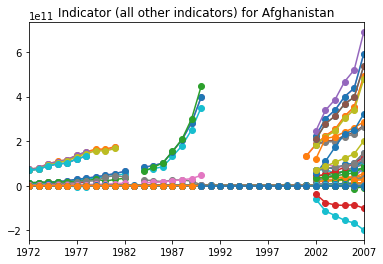

In [84]:
df_afghanistan_not_7_8 = df[ (df["Country_Name"] == "Afghanistan") & (df["Series_Code"] != "7.8")]
df_afghanistan_not_7_8_1972_to_2007 = df_afghanistan_not_7_8.loc[:, "1972":"2007"]
df_afghanistan_not_7_8_1972_to_2007.T.plot(marker="o", title="Indicator (all other indicators) for Afghanistan", legend=False)

### Plotting all indicators except Environmental Sustainability (7.8) for Afghanistan for 2001 to 2007

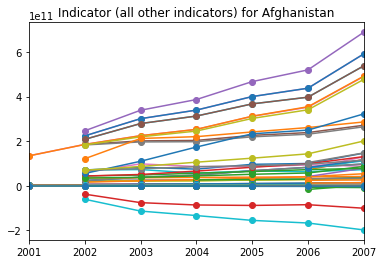

In [85]:
df_afghanistan_not_7_8 = df[ (df["Country_Name"] == "Afghanistan") & (df["Series_Code"] != "7.8")]
df_afghanistan_not_7_8_1972_to_2001 = df_afghanistan_not_7_8.loc[:, "2001":"2007"]
df_afghanistan_not_7_8_1972_to_2001.T.plot(marker="o", title="Indicator (all other indicators) for Afghanistan", legend=False)

### Enlisting top correlated features against target feature [Environmental Sustainability (7.8)]

In [86]:
df_afghanistan = df[ df["Country_Name"] == "Afghanistan" ]

df_2000_2007 = df_afghanistan.loc[:, "2000":"2007"]
df_2000_2007_clean_index = df_2000_2007.count(axis=1) >= 4


data = df_afghanistan[df_2000_2007_clean_index].set_index('Series_Code').loc[:, "2000":"2007"].T

coeff = data.corr().loc["7.8"].abs()
coeff.sort_values(inplace=True, ascending=False)
coeff.iloc[0:20]

Series_Code
7.8                  1.000000
SH.H2O.SAFE.UR.ZS    0.999991
SH.H2O.SAFE.RU.ZS    0.999980
SP.RUR.TOTL.ZS       0.999972
SP.URB.TOTL.IN.ZS    0.999972
SH.STA.ACSN.UR       0.999958
4.1                  0.999815
SP.DYN.IMRT.IN       0.999794
SP.URB.TOTL          0.999742
SH.STA.ACSN          0.999618
SH.DYN.NMRT          0.999542
SP.DYN.CDRT.IN       0.999375
SP.POP.TOTL          0.999343
EN.POP.DNST          0.999343
SL.TLF.TOTL.IN       0.999190
SP.DYN.LE00.FE.IN    0.999073
SP.DYN.AMRT.FE       0.999012
SP.RUR.TOTL          0.998992
SP.DYN.LE00.IN       0.998971
SP.DYN.AMRT.MA       0.998868
Name: 7.8, dtype: float64

### Plotting the top correlated indicators for Afghanisthan between 2000 to 2007

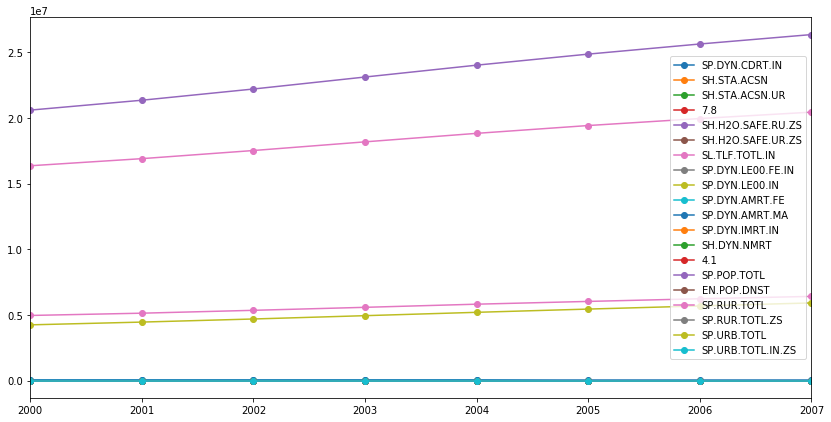

In [87]:
series_code_correlated_to_7_8 = coeff.iloc[0:20].index
df_afghanistan_indicators_correlated_to_7_8 = df_afghanistan[df_afghanistan.Series_Code.isin(series_code_correlated_to_7_8)]
df_afghanistan_indicators_correlated_to_7_8.set_index('Series_Code', inplace=True)
plt.rcParams["figure.figsize"] = (14,7)
df_afghanistan_indicators_correlated_to_7_8.loc[:, "2000":"2007"].T.plot(marker="o", legend=True)
plt.legend(loc=5)

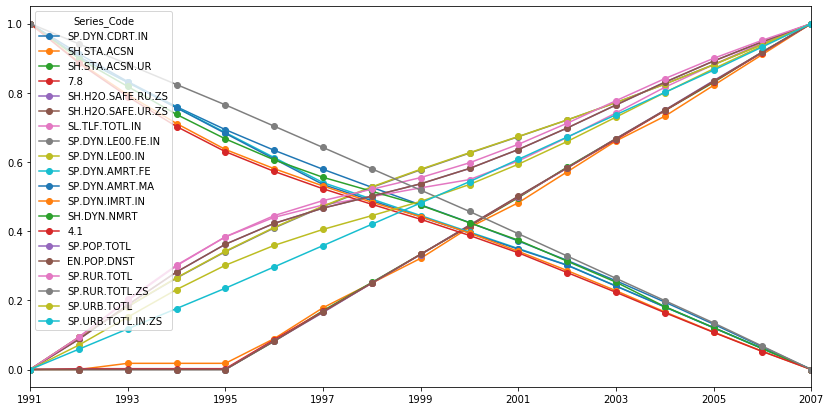

In [88]:
from sklearn.preprocessing import normalize, scale, MinMaxScaler
scaled_df = df_afghanistan_indicators_correlated_to_7_8.loc[:,'1972':'2007'].T
# print(scaled_df.shape)
# display(scaled_df.head(20))
scaled_df = scaled_df.dropna()
# scaled2_norm_df = pd.DataFrame(normalize(scaled_df, axis=0), columns=scaled_df.columns, index=scaled_df.index)
# scaled2_scale_df = pd.DataFrame(scale(scaled_df, axis=0), columns=scaled_df.columns, index=scaled_df.index)
scaled2_MinMax_df = pd.DataFrame(MinMaxScaler().fit_transform(scaled_df), columns=scaled_df.columns, index=scaled_df.index)
# display(scaled_df.head(20))
# scaled2_norm_df.plot(marker="o", legend=True)
# scaled2_scale_df.plot(marker="o", legend=True)
scaled2_MinMax_df.plot(marker="o", legend=True);

In [89]:
pred_columns = [str(item) + "_pred" for item in np.array(range(2002,2008))]
true_columns = [str(item) for item in range(2002,2008)]

def make_prediction(row):
    training_data = row.loc['1972':'2002']
    test_data = row.loc['2002':'2007']
    
    nbr_data_points = training_data.count()
    if test_data.count()<6 or training_data.count() < 6 :
        return  [None]*6
    else:
        years = training_data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = training_data.dropna().values
        
        #linear regression
        regr = LinearRegression()
        regr.fit(years, values)
        
        #predictions
        return regr.predict(np.array(range(2002,2008)).reshape(-1, 1))


In [90]:
%pdb 0
from pdb import set_trace
from sklearn.metrics import mean_squared_error

Automatic pdb calling has been turned OFF


In [91]:
def count_nas(df):
    return df.isna().sum().sum()

In [92]:
df = df_submission_in_data.dropna(subset=true_columns)
df_simple_preds_true_columns = pd.DataFrame(df.apply(make_prediction, axis=1).tolist(),\
                               index=df.index, columns=true_columns)

In [93]:
df_simple_preds.shape

(737, 2)

In [94]:
df_simple_preds_true_columns.shape

(697, 6)

In [95]:
scaled_df.shape

(17, 20)

In [96]:
scaler = MinMaxScaler()
scaled_df_submission = df_submission_in_data.loc[:,'1972':'2007']
scaled_df_submission = scaled_df_submission.dropna()
scaled2_MinMax_df_submission = pd.DataFrame(scaler.fit_transform(scaled_df_submission), columns=scaled_df_submission.columns, index=scaled_df_submission.index)

In [97]:
scaled2_MinMax_df_submission.shape

(148, 36)

In [98]:
scaled2_MinMax_df_dropna = scaled2_MinMax_df_submission.dropna(subset=true_columns)
scaled2_MinMax_df_preds = pd.DataFrame(scaled2_MinMax_df_dropna.apply(make_prediction, axis=1).tolist(),\
                               index=scaled2_MinMax_df_dropna.index, columns=true_columns)

In [99]:
scaled2_MinMax_df_true_columns = scaled2_MinMax_df_dropna[true_columns]
scaled2_MinMax_df_true_columns.shape

(148, 6)

In [100]:
scaled2_MinMax_df_preds.shape

(148, 6)

In [101]:
count_nas(scaled2_MinMax_df_true_columns)

0

In [102]:
scaled2_MinMax_df_true_columns.head(2)

,2002,2003,2004,2005,2006,2007
753,0.125452,0.121878,0.119000,0.115870,0.112646,0.109700
3427,0.027856,0.026145,0.024909,0.023618,0.022408,0.021496


In [103]:
count_nas(scaled2_MinMax_df_preds)

0

In [104]:
scaled2_MinMax_df_preds.head(2)

,2002,2003,2004,2005,2006,2007
753,0.108071,0.101877,0.095683,0.089488,0.083294,0.077099
3427,-0.014307,-0.021623,-0.028940,-0.036256,-0.043572,-0.050889


In [105]:
def assert_all_finite(X):
    X = np.asanyarray(X)
    return (X.dtype.char in np.typecodes['AllFloat'] and np.isfinite(X.sum())
            and np.isfinite(X).all())

In [106]:
def validate(y_true, y_pred):
    y_true_df = y_true.copy()
    y_pred_df = y_pred.dropna()
    validate = y_true_df.loc[y_pred_df.index][true_columns]
    assert(assert_all_finite(validate.dropna()))
    assert(assert_all_finite(y_pred_df))
    return mean_squared_error(validate.dropna(), y_pred_df)
# should return the dispersion of the errors as well

print(validate(scaled2_MinMax_df_true_columns, scaled2_MinMax_df_preds))

0.0003382664053419795


In [107]:
retained_columns = ['Country_Name', 'Series_Code', 'Series_Name']

In [108]:
df_submission_in_data_dropna = df_submission_in_data.dropna(subset=true_columns)

In [109]:
df_submission_in_data_no_years = df_submission_in_data_dropna[retained_columns]

In [110]:
df_merged = pd.merge(scaled2_MinMax_df_true_columns, df_submission_in_data_no_years, left_index=True, right_index=True, how='outer', suffixes=('',''))

In [111]:
df_merged.dropna(inplace=True)
df_merged.shape

(148, 9)

In [112]:
assert(df_submission_in_data.shape[0] == df_simple_preds.shape[0])

In [113]:
# plot_predictions(df_submission_in_data, df_simple_preds, 16)

In [114]:
assert(df_merged.shape[0] == scaled2_MinMax_df_preds.shape[0])

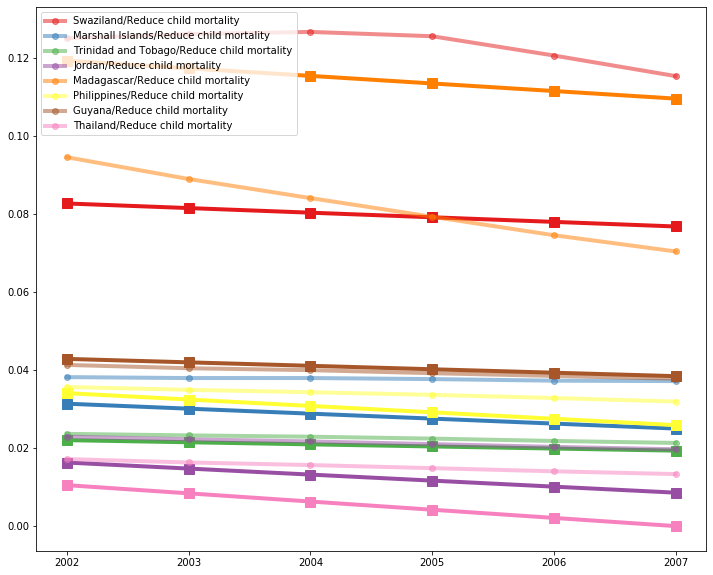

In [119]:
plot_predictions(df_merged, scaled2_MinMax_df_preds, 8)

## 12/06/2019 Setup polynomial model

In [193]:
pred_columns = [str(item) + "_pred" for item in np.array(range(2002,2008))]
true_columns = [str(item) for item in range(2002,2008)]

def make_prediction(row, model):
    training_data = row.loc['1972':'2002']
    test_data = row.loc['2002':'2007']
    
    nbr_data_points = training_data.count()
    if test_data.count()<6 or training_data.count() < 6 :
        return  [None]*6
    else:
        years = training_data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = training_data.dropna().values
        
        model.fit(years, values)
        
        #predictions
        return model.predict(np.array(range(2002,2008)).reshape(-1, 1))


### Linear Regression baseline

In [264]:

#linear regression
model = LinearRegression()

df = df_submission_in_data.dropna(subset=true_columns)
df_simple_preds_true_columns = pd.DataFrame(df.apply(make_prediction, args=(model,),axis=1).tolist(),\
                               index=df.index, columns=true_columns)

In [265]:
scaler = MinMaxScaler()
scaled_df_submission = df_submission_in_data.loc[:,'1972':'2007']
scaled_df_submission = scaled_df_submission.dropna()
scaled_df_submission = scaled_df_submission.dropna(subset=true_columns)
scaled_df_submission = pd.DataFrame(scaler.fit_transform(scaled_df_submission), columns=scaled_df_submission.columns, index=scaled_df_submission.index)

In [266]:
scaled_df_submission_preds = pd.DataFrame(scaled_df_submission.apply(make_prediction, args=(model,),axis=1).tolist(),\
                               index=scaled_df_submission.index, columns=true_columns)

In [267]:
print(validate(scaled_df_submission, scaled_df_submission_preds))

0.0003382664053419795


In [268]:
df_submission_in_data_dropna = df_submission_in_data.dropna(subset=true_columns)
df_submission_in_data_no_years = df_submission_in_data_dropna[retained_columns]
df_merged = pd.merge(scaled_df_submission, df_submission_in_data_no_years, left_index=True, right_index=True, how='outer', suffixes=('',''))
df_merged.dropna(subset=true_columns,inplace=True)

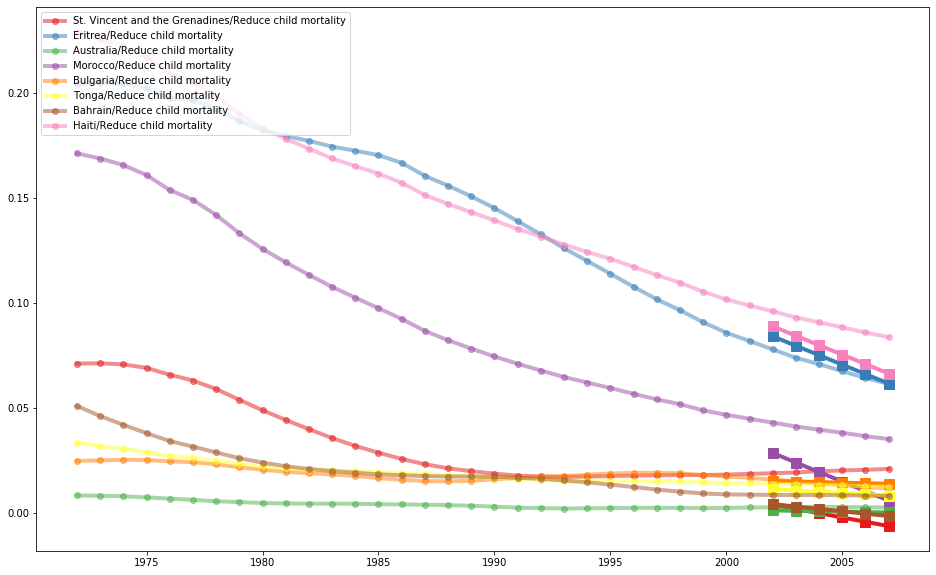

In [269]:
# df_merged = pd.merge(scaled_df_submission, df_submission_in_data_no_years, left_index=True, right_index=True, how='outer', suffixes=('',''))
plot_predictions(df_merged, scaled_df_submission_preds, 8)

### Polynomial regression baseline

In [193]:
pred_columns = [str(item) + "_pred" for item in np.array(range(2002,2008))]
true_columns = [str(item) for item in range(2002,2008)]

def make_prediction(row, model):
    training_data = row.loc['1972':'2002']
    test_data = row.loc['2002':'2007']
    
    nbr_data_points = training_data.count()
    if test_data.count()<6 or training_data.count() < 6 :
        return  [None]*6
    else:
        years = training_data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = training_data.dropna().values
        
        model.fit(years, values)
        
        #predictions
        return model.predict(np.array(range(2002,2008)).reshape(-1, 1))


In [253]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = LinearRegression()

df = df_submission_in_data.dropna(subset=true_columns)
# df.loc[:,'1972':'2007'].head()
df=df.loc[:,'2005':'2007']
df=df.iloc[0:2,:]
display(df.head())
transformer = PolynomialFeatures(degree=1)
df_poly=transformer.fit_transform(df.T)
print(df_poly)
transformer = PolynomialFeatures(degree=2,interaction_only=False)
df_poly=transformer.fit_transform(df.T)
print(df_poly)
transformer = PolynomialFeatures(degree=2,interaction_only=True)
df_poly=transformer.fit_transform(df.T)
print(df_poly)
# df_simple_preds_true_columns = pd.DataFrame(df.apply(make_prediction, args=(model,),axis=1).tolist(),\
#                                index=df.index, columns=true_columns)

,2005,2006,2007
559,0.395000,0.430000,0.465
618,0.012241,0.021071,0.019


[[1.         0.395      0.01224148]
 [1.         0.43       0.02107124]
 [1.         0.465      0.019     ]]
[[1.00000000e+00 3.95000000e-01 1.22414808e-02 1.56025000e-01
  4.83538493e-03 1.49853853e-04]
 [1.00000000e+00 4.30000000e-01 2.10712365e-02 1.84900000e-01
  9.06063168e-03 4.43997006e-04]
 [1.00000000e+00 4.65000000e-01 1.90000000e-02 2.16225000e-01
  8.83500000e-03 3.61000000e-04]]
[[1.         0.395      0.01224148 0.00483538]
 [1.         0.43       0.02107124 0.00906063]
 [1.         0.465      0.019      0.008835  ]]


In [276]:
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# tried degree 3 but did not look better

In [277]:
scaler = MinMaxScaler()
scaled_df_submission = df_submission_in_data.loc[:,'1972':'2007']
scaled_df_submission = scaled_df_submission.dropna()
scaled_df_submission = scaled_df_submission.dropna(subset=true_columns)
scaled_df_submission = pd.DataFrame(scaler.fit_transform(scaled_df_submission), columns=scaled_df_submission.columns, index=scaled_df_submission.index)

In [278]:
scaled_df_submission_preds = pd.DataFrame(scaled_df_submission.apply(make_prediction, args=(model,),axis=1).tolist(),\
                               index=scaled_df_submission.index, columns=true_columns)

In [279]:
print(validate(scaled_df_submission, scaled_df_submission_preds))

0.00026644798681812093


In [280]:
df_submission_in_data_dropna = df_submission_in_data.dropna(subset=true_columns)
df_submission_in_data_no_years = df_submission_in_data_dropna[retained_columns]
df_merged = pd.merge(scaled_df_submission, df_submission_in_data_no_years, left_index=True, right_index=True, how='outer', suffixes=('',''))
df_merged.dropna(subset=true_columns,inplace=True)

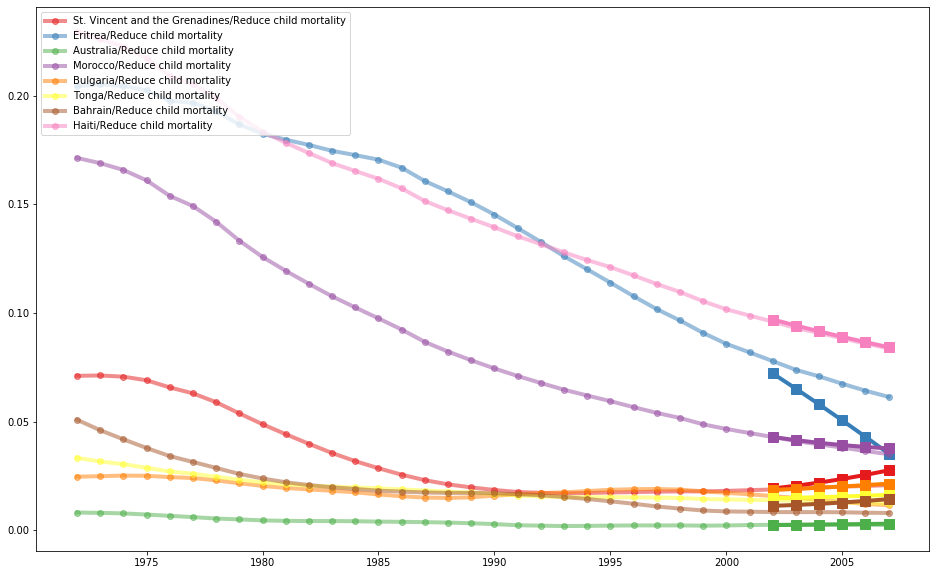

In [281]:
# df_merged = pd.merge(scaled_df_submission, df_submission_in_data_no_years, left_index=True, right_index=True, how='outer', suffixes=('',''))
plot_predictions(df_merged, scaled_df_submission_preds, 8)